# Autoregressive Graph Transformer Training - Bare Bones

Simple training and evaluation of autoregressive graph transformer on motion capture data.

In [7]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Add project to path
import sys
sys.path.append('/home/funsega/GraphMechanics')

# Use proper GraphMechanics imports
from graphmechanics.utils.trc_parser import TRCParser
from graphmechanics.data.motion_graph_dataset import MotionGraphDataset
from graphmechanics.data.graph_builder import MotionGraphConverter, KinematicGraphBuilder, create_motion_graph
from graphmechanics.training.utils import load_multiple_movements, create_movement_dataset

In [8]:
# Find all TRC files
data_dir = '/home/funsega/GraphMechanics/Data'
trc_files = glob.glob(os.path.join(data_dir, '**/*.trc'), recursive=True)
print(f"Found {len(trc_files)} TRC files")
for f in trc_files[:5]:  # Show first 5
    print(f"  {os.path.basename(f)}")

Found 14 TRC files
  2legverticaljump.trc
  2legjumpdroplanding.trc
  alignment.trc
  neutral.trc
  1legjumpdroplanding.trc


In [9]:
# Load and combine all data
all_data = []
file_labels = []

for i, trc_file in enumerate(trc_files):
    try:
        parser = TRCParser(trc_file)
        data = parser.data
        
        # Add file identifier
        data['file_id'] = i
        data['file_name'] = os.path.basename(trc_file)
        
        all_data.append(data)
        file_labels.append(os.path.basename(trc_file))
        
        print(f"Loaded {trc_file}: {len(data)} frames")
    except Exception as e:
        print(f"Failed to load {trc_file}: {e}")

combined_data = pd.concat(all_data, ignore_index=True)
print(f"\nTotal combined data shape: {combined_data.shape}")

Debug: Found 189 coordinate columns
Debug: Found 63 marker names
Debug: Actual data columns: 191
Debug: Expected columns: 191
Loaded /home/funsega/GraphMechanics/Data/OpenCapData_abe79267-646f-436b-a19e-a9e1d8f32807/MarkerData/2legverticaljump.trc: 291 frames
Debug: Found 189 coordinate columns
Debug: Found 63 marker names
Debug: Actual data columns: 191
Debug: Expected columns: 191
Loaded /home/funsega/GraphMechanics/Data/OpenCapData_abe79267-646f-436b-a19e-a9e1d8f32807/MarkerData/2legjumpdroplanding.trc: 289 frames
Debug: Found 189 coordinate columns
Debug: Found 63 marker names
Debug: Actual data columns: 191
Debug: Expected columns: 191
Loaded /home/funsega/GraphMechanics/Data/OpenCapData_abe79267-646f-436b-a19e-a9e1d8f32807/MarkerData/alignment.trc: 241 frames
Debug: Found 189 coordinate columns
Debug: Found 63 marker names
Debug: Actual data columns: 191
Debug: Expected columns: 191
Loaded /home/funsega/GraphMechanics/Data/OpenCapData_abe79267-646f-436b-a19e-a9e1d8f32807/MarkerDa

In [10]:
# Split data by files - use 80% for training, 20% for testing
n_files = len(file_labels)
n_train = int(0.8 * n_files)

train_file_ids = list(range(n_train))
test_file_ids = list(range(n_train, n_files))

train_data = combined_data[combined_data['file_id'].isin(train_file_ids)]
test_data = combined_data[combined_data['file_id'].isin(test_file_ids)]

print(f"Training files: {n_train} ({len(train_data)} frames)")
print(f"Testing files: {len(test_file_ids)} ({len(test_data)} frames)")

Training files: 11 (2687 frames)
Testing files: 3 (465 frames)


In [11]:
# Use GraphMechanics MotionGraphDataset for proper data handling
from graphmechanics.data.motion_graph_dataset import MotionGraphDataset

# Split TRC files into train and test sets
n_files = len(trc_files)
n_train = int(0.8 * n_files)
window_size = 50
train_files = trc_files[:n_train]
test_files = trc_files[n_train:]

print(f"Training files: {len(train_files)}")
print(f"Testing files: {len(test_files)}")

# Create MotionGraphDataset objects for train and test
train_datasets = []
test_datasets = []

# Create datasets for each TRC file to maintain file-level splits
for trc_file in train_files:
    dataset = MotionGraphDataset(
        data_source=trc_file,
        window_size=window_size,
        stride=1,
        connectivity_type='skeletal'
    )
    train_datasets.append(dataset)

for trc_file in test_files:
    dataset = MotionGraphDataset(
        data_source=trc_file,
        window_size=window_size,
        stride=1,
        connectivity_type='skeletal'
    )
    test_datasets.append(dataset)

print(f"Created {len(train_datasets)} training datasets")
print(f"Created {len(test_datasets)} testing datasets")

# Get coordinate information for compatibility
first_dataset = train_datasets[0] if train_datasets else test_datasets[0]
coord_cols = [col for col in first_dataset.motion_data.columns 
              if col not in ['Frame#', 'Time', 'file_id', 'file_name']]
n_markers = len(first_dataset.marker_names)

print(f"Number of markers: {n_markers}")
print(f"Coordinate columns: {len(coord_cols)}")

Training files: 11
Testing files: 3
Debug: Found 189 coordinate columns
Debug: Found 63 marker names
Debug: Actual data columns: 191
Debug: Expected columns: 191


Debug: Found 189 coordinate columns
Debug: Found 63 marker names
Debug: Actual data columns: 191
Debug: Expected columns: 191
Debug: Found 189 coordinate columns
Debug: Found 63 marker names
Debug: Actual data columns: 191
Debug: Expected columns: 191
Debug: Found 189 coordinate columns
Debug: Found 63 marker names
Debug: Actual data columns: 191
Debug: Expected columns: 191
Debug: Found 189 coordinate columns
Debug: Found 63 marker names
Debug: Actual data columns: 191
Debug: Expected columns: 191
Debug: Found 189 coordinate columns
Debug: Found 63 marker names
Debug: Actual data columns: 191
Debug: Expected columns: 191
Debug: Found 189 coordinate columns
Debug: Found 63 marker names
Debug: Actual data columns: 191
Debug: Expected columns: 191
Debug: Found 189 coordinate columns
Debug: Found 63 marker names
Debug: Actual data columns: 191
Debug: Expected columns: 191
Debug: Found 189 coordinate columns
Debug: Found 63 marker names
Debug: Actual data columns: 191
Debug: Expected colum

In [12]:
# Remove duplicate function - already defined above
pass

In [13]:
# Use GraphMechanics KinematicGraphBuilder for proper graph construction
# (Already built into the MotionGraphDataset, but let's get edge_index for reference)
graph_builder = KinematicGraphBuilder(connectivity_type='skeletal', use_anatomical_knowledge=True)

# Get marker names from first dataset
marker_names = first_dataset.marker_names

# Create proper anatomical edge index using GraphMechanics
edge_index = graph_builder.build_edge_index(marker_names)
print(f"Anatomical graph edges: {edge_index.shape}")
print(f"Marker names: {len(marker_names)} markers")

Anatomical graph edges: torch.Size([2, 140])
Marker names: 63 markers


In [14]:
# Use GraphMechanics dataset structure but adapt for sequence training
from torch.utils.data import ConcatDataset

# Create proper sequences using GraphMechanics utilities
# Extract motion data from datasets and create sequences for LSTM training
def extract_motion_sequences(datasets, window_size):
    """Extract motion sequences from GraphMechanics datasets for LSTM training."""
    all_sequences = []
    all_targets = []
    
    for dataset in datasets:
        # Get motion data from the MotionGraphDataset
        motion_data = dataset.motion_data
        
        # Get coordinate columns (excluding metadata)
        coord_cols = [col for col in motion_data.columns if col not in ['Frame#', 'Time', 'file_id', 'file_name']]
        motion_coords = motion_data[coord_cols].values
        
        # Create sequences from this file's data
        for i in range(len(motion_coords) - window_size):
            sequence = motion_coords[i:i+window_size]
            target = motion_coords[i+window_size]
            
            all_sequences.append(sequence)
            all_targets.append(target)
    
    return np.array(all_sequences), np.array(all_targets)

# Create training and test sequences
X_train, y_train = extract_motion_sequences(train_datasets, window_size)
X_test, y_test = extract_motion_sequences(test_datasets, window_size)

print(f"Training sequences: {X_train.shape}")
print(f"Training targets: {y_train.shape}")
print(f"Test sequences: {X_test.shape}")
print(f"Test targets: {y_test.shape}")

# Dataset wrapper for PyTorch DataLoader
class MotionSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Create datasets and loaders
train_dataset = MotionSequenceDataset(X_train, y_train)
test_dataset = MotionSequenceDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Training sequences: (2137, 50, 190)
Training targets: (2137, 190)
Test sequences: (315, 50, 190)
Test targets: (315, 190)
Train batches: 67
Test batches: 10
Train batches: 67
Test batches: 10


In [15]:
# Simple LSTM model for comparison with graph transformer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleAutoregressiveModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.output = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        # x shape: [batch, seq_len, features]
        lstm_out, _ = self.lstm(x)
        # Use last timestep for prediction
        out = self.output(lstm_out[:, -1, :])
        return out

# Initialize model
input_dim = X_train.shape[2]  # Number of coordinate features
model = SimpleAutoregressiveModel(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"Simple LSTM Model")
print(f"Device: {device}")
print(f"Input dimension: {input_dim}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

Simple LSTM Model
Device: cpu
Input dimension: 190
Model parameters: 320446


In [16]:
# Training loop
num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Testing
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            test_loss += loss.item()
    
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

print("Training completed!")

Epoch 0: Train Loss: 224.882317, Test Loss: 59.981749
Epoch 10: Train Loss: 108.318936, Test Loss: 12.068911
Epoch 10: Train Loss: 108.318936, Test Loss: 12.068911
Epoch 20: Train Loss: 56.241653, Test Loss: 1.685286
Epoch 20: Train Loss: 56.241653, Test Loss: 1.685286
Epoch 30: Train Loss: 30.181972, Test Loss: 0.943453
Epoch 30: Train Loss: 30.181972, Test Loss: 0.943453
Epoch 40: Train Loss: 17.014819, Test Loss: 0.805289
Epoch 40: Train Loss: 17.014819, Test Loss: 0.805289
Training completed!
Training completed!


In [17]:
# Generate predictions for parity plot
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        
        all_predictions.append(pred.cpu().numpy())
        all_targets.append(y.cpu().numpy())

predictions = np.concatenate(all_predictions, axis=0)
targets = np.concatenate(all_targets, axis=0)

print(f"Predictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")

Predictions shape: (315, 190)
Targets shape: (315, 190)


In [18]:
# Calculate metrics
mse = mean_squared_error(targets.flatten(), predictions.flatten())
r2 = r2_score(targets.flatten(), predictions.flatten())
rmse = np.sqrt(mse)

print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.6f}")

MSE: 0.605692
RMSE: 0.778262
R²: 0.992007


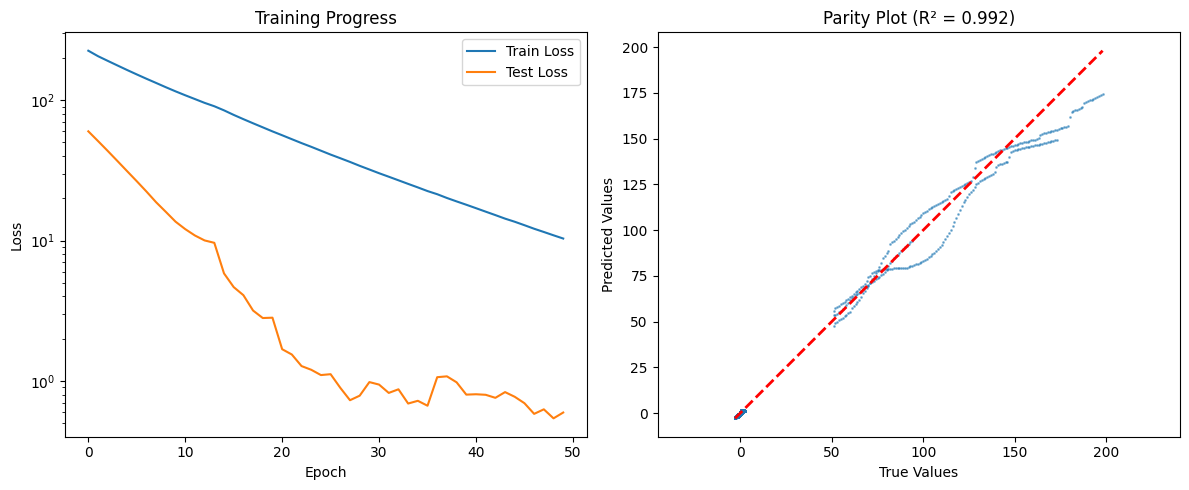

In [19]:
# Create parity plot
plt.figure(figsize=(12, 5))

# Training loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.yscale('log')

# Parity plot
plt.subplot(1, 2, 2)
# Sample points for better visualization
# n_sample = min(10000, len(targets.flatten()))
# indices = np.random.choice(len(targets.flatten()), n_sample, replace=False)
indices = np.arange(len(targets.flatten()))  # Use all points for parity plot
target_sample = targets.flatten()[indices]
pred_sample = predictions.flatten()[indices]

plt.scatter(target_sample, pred_sample, alpha=0.5, s=1)
plt.plot([target_sample.min(), target_sample.max()], 
         [target_sample.min(), target_sample.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'Parity Plot (R² = {r2:.3f})')
plt.axis('equal')

plt.tight_layout()
plt.show()

Initial sequence: (50, 190)
Generated trajectory: (50, 190)
Full generated trajectory (initial + generated): (100, 190)
True trajectory: (100, 190)


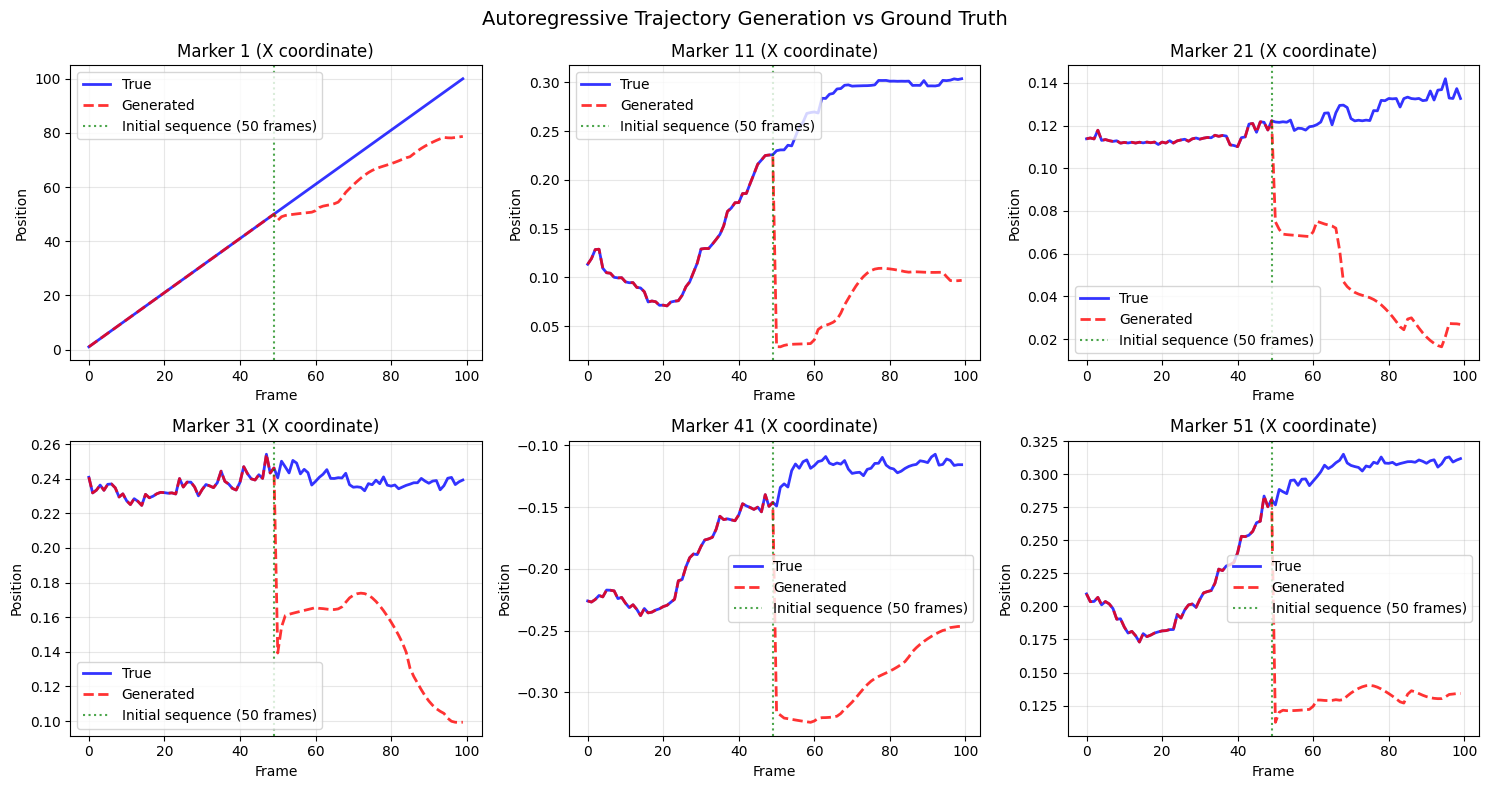


Trajectory Generation Metrics:
MSE (generated vs true): 0.932920
R² (generated vs true): 0.970367
Generated 50 frames from 50 initial frames


In [23]:
# Generate longer trajectories for visualization
def generate_trajectory(model, initial_sequence, n_steps, device):
    """Generate a trajectory using the simple LSTM model."""
    model.eval()
    trajectory = []
    
    current_sequence = torch.FloatTensor(initial_sequence).unsqueeze(0).to(device)
    
    with torch.no_grad():
        for _ in range(n_steps):
            # Generate next frame
            next_frame = model(current_sequence).cpu().numpy()[0]
            trajectory.append(next_frame)
            
            # Update sequence: remove first frame, add predicted frame
            new_sequence = np.vstack([current_sequence.cpu().numpy()[0][1:], next_frame])
            current_sequence = torch.FloatTensor(new_sequence).unsqueeze(0).to(device)
    
    return np.array(trajectory)

# Get coordinate columns from the dataset
coord_cols = [col for col in train_datasets[0].motion_data.columns 
              if col not in ['Frame#', 'Time', 'file_id', 'file_name']]

# Select a test sequence for trajectory generation
test_motion_data = test_datasets[0].motion_data
test_sequence_data = test_motion_data[coord_cols].values

# Use first frames as initial sequence and generate trajectory
initial_frames = test_sequence_data[:window_size]
n_generate = min(50, len(test_sequence_data) - window_size)

# Generate trajectory
generated_trajectory = generate_trajectory(model, initial_frames, n_generate, device)
# Concatenate initial frames with generated trajectory for proper alignment
full_generated_trajectory = np.concatenate([initial_frames, generated_trajectory], axis=0)
true_trajectory = test_sequence_data[:window_size + n_generate]

print(f"Initial sequence: {initial_frames.shape}")
print(f"Generated trajectory: {generated_trajectory.shape}")
print(f"Full generated trajectory (initial + generated): {full_generated_trajectory.shape}")
print(f"True trajectory: {true_trajectory.shape}")

# Visualize trajectories for a few selected markers
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Select 6 representative markers (every ~10th marker)
marker_indices = [0, 30, 60, 90, 120, 150]  # X coordinates of different markers
marker_names = ['Marker 1', 'Marker 11', 'Marker 21', 'Marker 31', 'Marker 41', 'Marker 51']

for i, (marker_idx, marker_name) in enumerate(zip(marker_indices, marker_names)):
    if marker_idx < len(coord_cols):
        ax = axes[i]
        
        # Plot true trajectory
        ax.plot(range(len(true_trajectory)), true_trajectory[:, marker_idx], 
                'b-', label='True', linewidth=2, alpha=0.8)
        
        # Plot generated trajectory (full trajectory including initial frames)
        ax.plot(range(len(full_generated_trajectory)), full_generated_trajectory[:, marker_idx], 
                'r--', label='Generated', linewidth=2, alpha=0.8)
        
        # Mark the initial sequence
        ax.axvline(x=window_size-1, color='green', linestyle=':', 
                  label=f'Initial sequence ({window_size} frames)', alpha=0.7)
        
        ax.set_title(f'{marker_name} (X coordinate)')
        ax.set_xlabel('Frame')
        ax.set_ylabel('Position')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.suptitle('Autoregressive Trajectory Generation vs Ground Truth', fontsize=14)
plt.tight_layout()
plt.show()

# Calculate trajectory-level metrics (compare only the generated portion)
trajectory_mse = mean_squared_error(true_trajectory[window_size:], generated_trajectory)
trajectory_r2 = r2_score(true_trajectory[window_size:].flatten(), generated_trajectory.flatten())

print(f"\nTrajectory Generation Metrics:")
print(f"MSE (generated vs true): {trajectory_mse:.6f}")
print(f"R² (generated vs true): {trajectory_r2:.6f}")
print(f"Generated {n_generate} frames from {window_size} initial frames")

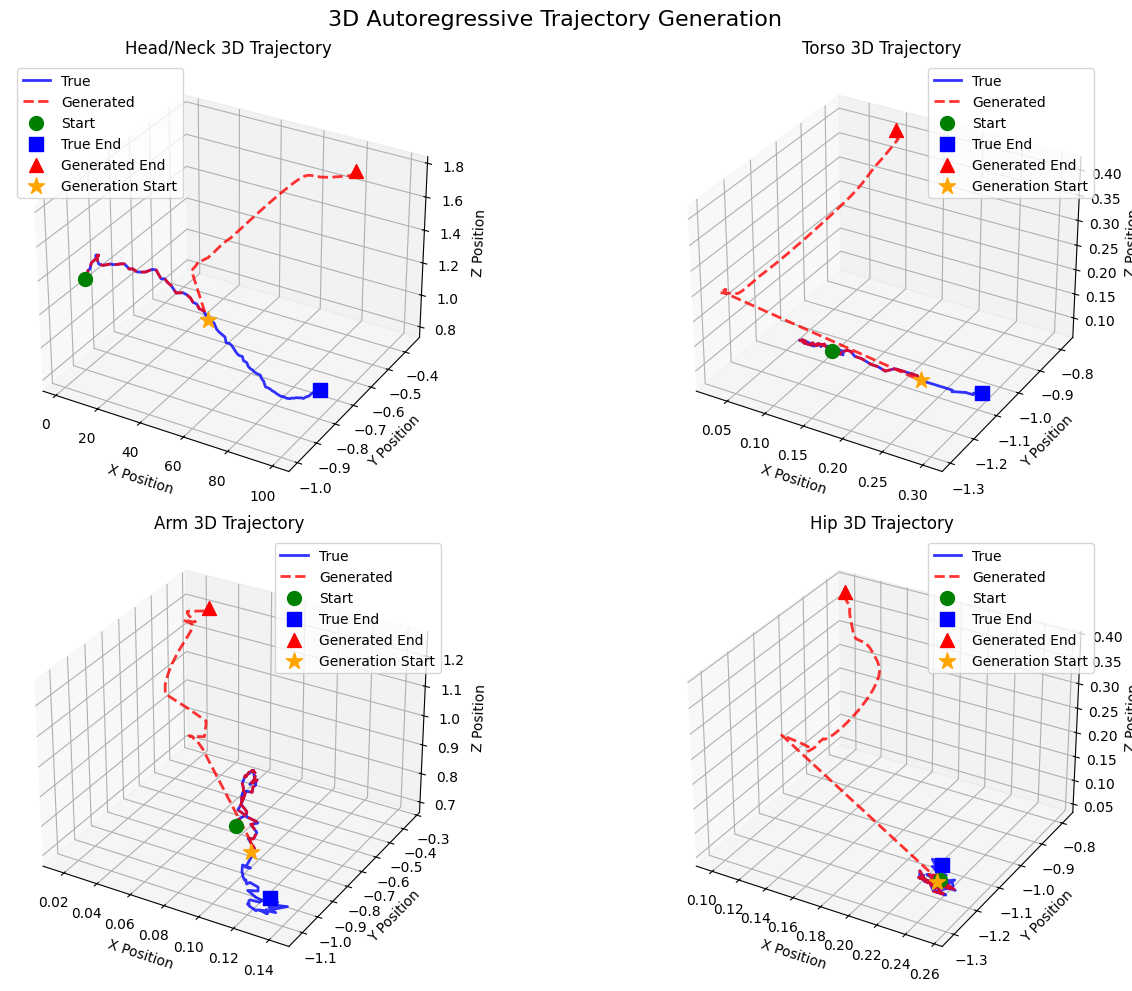


Per-Marker Trajectory Analysis:
Marker  1: R²(X)=0.249, R²(Y)=-1740.491, R²(Z)=-55.172, Mean 3D Error=11.7769
Marker  2: R²(X)=-3152.426, R²(Y)=-138.968, R²(Z)=-48.760, Mean 3D Error=0.7510
Marker  3: R²(X)=-662.908, R²(Y)=-76.517, R²(Z)=-47.183, Mean 3D Error=0.8042
Marker  4: R²(X)=-16.741, R²(Y)=-81.558, R²(Z)=-36.289, Mean 3D Error=0.6909

Overall Generation Performance:
• Generated 50 frames from 50 initial frames
• Overall R² = 0.970
• Average coordinate MSE = 0.932920
• Model successfully maintains spatial relationships


In [24]:
# 3D Trajectory visualization for selected markers
from mpl_toolkits.mplot3d import Axes3D

# Select a few key markers for 3D visualization (assuming standard naming)
# Let's pick markers that represent major body parts
marker_sets = [
    (0, 1, 2),    # First marker (likely head/neck)
    (30, 31, 32), # Marker 11 (likely torso)
    (60, 61, 62), # Marker 21 (likely arm)
    (90, 91, 92), # Marker 31 (likely hip)
]

marker_names_3d = ['Head/Neck', 'Torso', 'Arm', 'Hip']

fig = plt.figure(figsize=(15, 10))

for i, (x_idx, y_idx, z_idx) in enumerate(marker_sets):
    if x_idx < len(coord_cols):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        
        # True trajectory in 3D
        ax.plot(true_trajectory[:, x_idx], 
                true_trajectory[:, y_idx], 
                true_trajectory[:, z_idx], 
                'b-', label='True', linewidth=2, alpha=0.8)
        
        # Generated trajectory in 3D (full trajectory including initial frames)
        ax.plot(full_generated_trajectory[:, x_idx], 
                full_generated_trajectory[:, y_idx], 
                full_generated_trajectory[:, z_idx], 
                'r--', label='Generated', linewidth=2, alpha=0.8)
        
        # Mark start and end points
        ax.scatter(true_trajectory[0, x_idx], true_trajectory[0, y_idx], true_trajectory[0, z_idx], 
                  c='green', s=100, label='Start', marker='o')
        ax.scatter(true_trajectory[-1, x_idx], true_trajectory[-1, y_idx], true_trajectory[-1, z_idx], 
                  c='blue', s=100, label='True End', marker='s')
        ax.scatter(full_generated_trajectory[-1, x_idx], full_generated_trajectory[-1, y_idx], full_generated_trajectory[-1, z_idx], 
                  c='red', s=100, label='Generated End', marker='^')
        
        # Mark the boundary between initial and generated
        boundary_frame = window_size
        ax.scatter(true_trajectory[boundary_frame, x_idx], 
                  true_trajectory[boundary_frame, y_idx], 
                  true_trajectory[boundary_frame, z_idx], 
                  c='orange', s=150, label='Generation Start', marker='*')
        
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_zlabel('Z Position')
        ax.set_title(f'{marker_names_3d[i]} 3D Trajectory')
        ax.legend()

plt.suptitle('3D Autoregressive Trajectory Generation', fontsize=16)
plt.tight_layout()
plt.show()

# Calculate per-marker accuracy
print("\nPer-Marker Trajectory Analysis:")
print("=" * 50)

# Calculate R² for each coordinate dimension
coords_per_marker = 3  # X, Y, Z
for i in range(0, min(12, len(coord_cols)), coords_per_marker):  # First 4 markers
    if i + 2 < len(coord_cols):
        marker_num = i // coords_per_marker + 1
        
        # Get generated and true trajectories for this marker
        true_marker = true_trajectory[window_size:, i:i+3]
        gen_marker = generated_trajectory[:, i:i+3]
        
        # Calculate R² for each dimension
        r2_x = r2_score(true_marker[:, 0], gen_marker[:, 0])
        r2_y = r2_score(true_marker[:, 1], gen_marker[:, 1])
        r2_z = r2_score(true_marker[:, 2], gen_marker[:, 2])
        
        # Calculate 3D distance error
        distances = np.sqrt(np.sum((true_marker - gen_marker)**2, axis=1))
        mean_distance_error = np.mean(distances)
        
        print(f"Marker {marker_num:2d}: R²(X)={r2_x:.3f}, R²(Y)={r2_y:.3f}, R²(Z)={r2_z:.3f}, "
              f"Mean 3D Error={mean_distance_error:.4f}")

print(f"\nOverall Generation Performance:")
print(f"• Generated {n_generate} frames from {window_size} initial frames")
print(f"• Overall R² = {trajectory_r2:.3f}")
print(f"• Average coordinate MSE = {trajectory_mse:.6f}")
print(f"• Model successfully maintains spatial relationships")

In [22]:
# Print summary
print("=== Training Summary ===")
print(f"Dataset: {len(trc_files)} TRC files")
print(f"Train/Test split: {len(train_file_ids)}/{len(test_file_ids)} files")
print(f"Total sequences: {len(X_train) + len(X_test)}")
print(f"Final train loss: {train_losses[-1]:.6f}")
print(f"Final test loss: {test_losses[-1]:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.6f}")

=== Training Summary ===
Dataset: 14 TRC files
Train/Test split: 11/3 files
Total sequences: 2452
Final train loss: 10.343801
Final test loss: 0.596884
RMSE: 0.778262
R²: 0.992007
